In [1]:
import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,make_scorer,classification_report
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import numpy as np
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, cross_validate,GridSearchCV,RandomizedSearchCV,train_test_split

import seaborn as sns
sns.set_style("whitegrid")

In [2]:
np.set_printoptions(precision=6, suppress=True)

In [3]:

class FFT:
    def __init__(self,timeSeries,fs=160):
        self.getFFT(timeSeries)

    def getFFT(self, timeSeries,fs=160):
        self.N = len(timeSeries)
        self.T = 1/fs
        self.t = np.arange(0,self.N/fs,self.T)
        f = np.fft.fftfreq(self.N,self.T)
        # self.data,self.f = np.abs(np.fft.fft(timeSeries))[f>0],f[f>0]
        self.data,self.f = np.real(np.fft.fft(timeSeries))[f>0],f[f>0]

    def plotFFT(self):
        plt.figure()
        plt.plot(self.f,(self.data)*(1/self.N))
        plt.show()
        return

    # filtragem da rede (intervalo indicado é de 0.5 até 42.0 hz)
    def bandPassFilter(self,min,max):
        self.data = self.data[(self.f>min) & (self.f<max)]
        self.f = self.f[(self.f>min) & (self.f<max)]

    
def display_results(labels_test,rfc_pred):
    acc = accuracy_score(labels_test, rfc_pred)
    f1 = f1_score(labels_test, rfc_pred, average='macro')
    print(classification_report(labels_test,rfc_pred))

    aux_df = labels_test.drop_duplicates().sort_values()
    conf_matrix = confusion_matrix(labels_test, rfc_pred)
    plt.figure(figsize=(12.8,6))
    sns.heatmap(conf_matrix, 
                annot=True,
                xticklabels=aux_df.values, 
                yticklabels=aux_df.values,
                cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion matrix')
    plt.show()
    return f1,acc

In [72]:

metrics = []


subjects_range = range(1, 110)
files = [4,8,12]
for subject in subjects_range:
    if subject in [88, 92, 100]:
        continue
    for file in files:
        fileName = f'../downloaded_files/S{subject:03d}R{file:02d}.edf'
        
        reader = mne.io.read_raw_edf(fileName,preload=True, verbose=0)
        annotations = reader.annotations
        codes = annotations.description
        codeArray = []     
        counter = 0
        df = pd.DataFrame(reader.get_data().T, columns=[channel.replace(".","") for channel in reader.ch_names])
        df = df[~(df == 0).all(axis=1)]
        # df = df[160:min(len(df),19680)] # Filter first and last values
        timeArray = np.array([round(x,5) for x in np.arange(0,len(df)/160,.00625)])
        # timeArray = np.array([round(x,5) for x in np.arange(0,124.5,.00625)])

        for timeVal in timeArray:
            if timeVal in annotations.onset:
                counter += 1
            codeArray.append(codes[counter-1])

        df["target"] = np.array(codeArray[:len(df)]).T
        

        df.to_csv(f"../treated_files/S{subject:03d}R{file:02d}.csv")


In [4]:

metrics = []


subjects_range = range(1, 110)
files = [4,8,12]
for subject in subjects_range:
    if subject in [88, 92, 100]:
        continue
    for file in files:
        df = pd.read_csv(f"../treated_files/S{subject:03d}R{file:02d}.csv")

        # Iterate over unique target values
        window_size = 160
        shift_size = 80
        # for target_value in df['target'].unique():
            # Create a DataFrame for each target value
            # target_df = df[df['target'] == target_value]
            # target_df.reset_index(drop=True, inplace=True)
            # Create a list to store the windowed dataframes
        target_df = df
        # Iterate through the dataframe with the specified window and shift size
        for i in range(0, len(target_df) - window_size + 1, shift_size):
            
                # Extract the window of dat'a
                window_data = target_df[['Fp1','target']].iloc[i:i + window_size]
                if len(window_data) == 160:
                    fft = FFT(window_data['Fp1'])
                    fft.bandPassFilter(0.5,42)
                    data = {
                        'mean': [np.mean(fft.data)],
                        'max': [np.max(fft.data)],
                        'min': [np.min(fft.data)],
                        'fmax': [fft.f[np.argmax(fft.data)]],
                        'energy': [sum(np.abs(fft.data)*np.abs(fft.data))/len(fft.data)],
                        'target': window_data['target'][i]
                    }
                    metrics.append(pd.DataFrame(data))



        # df = df[df['target']!= "T0"]

        #         # Iterate over unique target values
        # window_size = 160
        # shift_size = 80
        # for target_value in df['target'].unique():
        #     target_df = df[df['target'] == target_value]
        #     target_df.reset_index(drop=True, inplace=True)
        # # target_df = df
        # # Iterate through the dataframe with the specified window and shift size
        #     for i in range(0, len(target_df) - window_size + 1, shift_size):
                
        #             # Extract the window of dat'a
        #             window_data = target_df[['Fp1','target']].iloc[i:i + window_size]
        #             if len(window_data) == 160:
        #                 fft = FFT(window_data['Fp1'])
        #                 fft.bandPassFilter(0.5,42)
        #                 data = {
        #                     'mean': [np.mean(fft.data)],
        #                     'max': [np.max(fft.data)],
        #                     'min': [np.min(fft.data)],
        #                     'fmax': [fft.f[np.argmax(fft.data)]],
        #                     'energy': [sum(np.abs(fft.data)*np.abs(fft.data))/len(fft.data)],
        #                     'target': window_data['target'][i]
        #                 }
        #                 metrics.append(pd.DataFrame(data))
                    
metrics = pd.concat(metrics, ignore_index=True)

In [5]:
metrics.loc[0]

mean       0.00008
max       0.002571
min      -0.001033
fmax           2.0
energy         0.0
target          T0
Name: 0, dtype: object

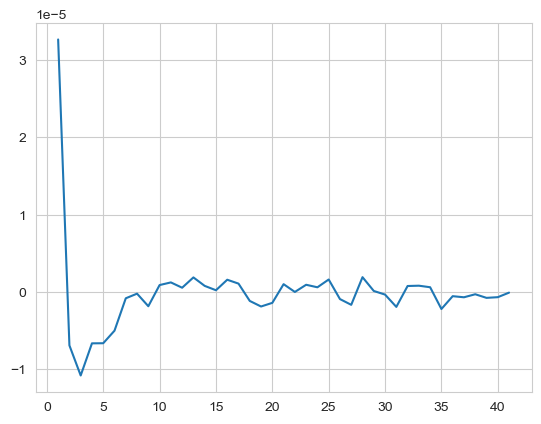

In [6]:
fft.plotFFT()

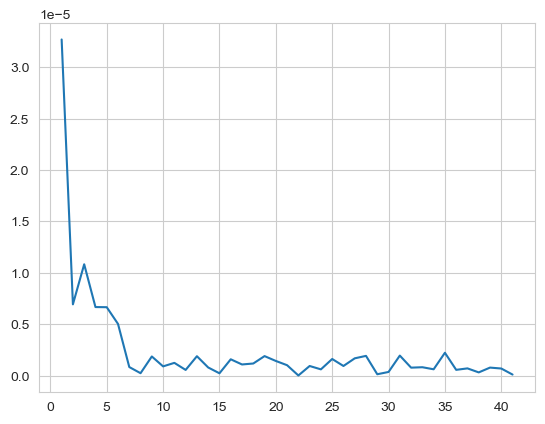

In [7]:

plt.figure()
plt.plot(fft.f,(np.abs(fft.data))*(1/fft.N))
plt.show()

In [8]:
metricsT2 = metrics.copy()
metricsT1 = metrics.copy()


In [9]:
metrics[metrics['target']!= "T0"]

,mean,max,min,fmax,energy,target
9,-0.000099,0.000962,-0.001457,2.0,1.612986e-07,T2
10,0.000011,0.001932,-0.003701,3.0,6.043280e-07,T2
11,0.000030,0.012219,-0.004448,1.0,4.845462e-06,T2
12,-0.000406,0.003026,-0.008972,3.0,2.781098e-06,T2
13,-0.000028,0.000674,-0.000703,5.0,7.168648e-08,T2
...,...,...,...,...,...,...
78067,-0.000021,0.000558,-0.000842,5.0,6.925372e-08,T1
78068,0.000055,0.000433,-0.000360,15.0,4.667232e-08,T1
78069,0.000006,0.001080,-0.000402,1.0,6.640893e-08,T1
78070,-0.000044,0.000380,-0.001601,2.0,1.102815e-07,T1


In [10]:
metricsT1 = metrics[metrics['target']!= "T0"].copy()


In [11]:
metricsT2.loc[metricsT2['target'] != 'T2', 'target'] = 0
metricsT2.loc[metricsT2['target'] == 'T2', 'target'] = 1

metricsT1.loc[metricsT1['target'] != 'T1', 'target'] = 0
metricsT1.loc[metricsT1['target'] == 'T1', 'target'] = 1


In [12]:
calcMetric = metricsT2.copy()

In [13]:
len(metricsT2)

78072

In [14]:
len(metricsT1)

38746

In [139]:
calcMetric["target"].value_counts()

0    58861
1    19211
Name: target, dtype: int64

In [140]:
y_train_full.value_counts()

0    41265
1    13385
Name: target, dtype: int64

In [146]:
pd.DataFrame(encoder.fit_transform(y_train_full.values.reshape(-1, 1))).value_counts()

0    1  
1.0  0.0    41265
0.0  1.0    13385
dtype: int64

In [117]:

# Supondo que você tenha os dados X e y para treinamento

X_train_full, X_val, y_train_full, y_val = train_test_split(calcMetric[["mean"	,"max"	,"min"	,"fmax"	,"energy"]], calcMetric["target"], test_size=0.3, random_state=37)
X_train_full = X_train_full.reset_index(drop=True)
y_train_full = y_train_full.reset_index(drop=True)
y_train_full = y_train_full.astype(int)


In [118]:
len(X_val)

23422

In [119]:

# Definir o número de folds para a validação cruzada


model = MLPClassifier(learning_rate_init= 0.3,max_iter= 500,momentum= 0.2,hidden_layer_sizes= (5, 3))

random_grid = {
               'activation': ['logistic'],
               'solver': ['sgd'],
               
               
               }


random_search = RandomizedSearchCV(estimator= model,param_distributions=random_grid,refit='F1',scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})
# Criar o modelo da rede neural


In [120]:
# skf = StratifiedKFold(n_splits=n_folds, shuffle=False, random_state=42)
# Iterar sobre os folds
# for train_index, test_index in skf.split(X_train_full, y_train_full):
X_train =  X_train_full
y_train = y_train_full


encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the target values
y_train = encoder.fit_transform(y_train.values.reshape(-1, 1))
# Treinar o modelo
random_search.fit(X_train, y_train)



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(estimator=MLPClassifier(hidden_layer_sizes=(5, 3),
                                           learning_rate_init=0.3, max_iter=500,
                                           momentum=0.2),
                   param_distributions={'activation': ['logistic'],
                                        'solver': ['sgd']},
                   refit='F1',
                   scoring={'Accuracy': make_scorer(accuracy_score),
                            'F1': 'f1_macro'})

In [121]:
random_search.predict(X_val)

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [122]:
model = Sequential()
model.add(Dense(5, input_dim=5, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(2, activation='softmax'))
optimizer = SGD(learning_rate=0.3, momentum=0.2)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])



In [123]:
# model.fit(X_train, y_train,validation_data=(X_val,encoder.fit_transform(y_val.values.reshape(-1, 1))))
model.fit(X_train, y_train)


1708/1708 [==============================] - 2s 1ms/step - loss: 0.5586 - accuracy: 0.7551


In [131]:
model.predict(X_train)

1708/1708 [==============================] - 2s 912us/step


array([[0.901604, 0.098396],
       [0.901604, 0.098396],
       [0.901604, 0.098396],
       ...,
       [0.901604, 0.098396],
       [0.901604, 0.098396],
       [0.901604, 0.098396]], dtype=float32)

In [136]:
pd.DataFrame(y_train).value_counts()

0    1  
1.0  0.0    41265
0.0  1.0    13385
dtype: int64

In [124]:
y_val.value_counts()

0    17596
1     5826
Name: target, dtype: int64

In [125]:
17615/(17615+5807)

0.7520707027580907

In [148]:
y_val.value_counts()

0    17596
1     5826
Name: target, dtype: int64

In [150]:
encoder.fit_transform(y_val.values.reshape(-1, 1))

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [149]:
pd.DataFrame(encoder.fit_transform(y_val.values.reshape(-1, 1))).value_counts()

0    1  
1.0  0.0    17596
0.0  1.0     5826
dtype: int64

In [127]:

a = model.predict(X_val)
a

732/732 [==============================] - 1s 848us/step


array([[0.901604, 0.098396],
       [0.901604, 0.098396],
       [0.901604, 0.098396],
       ...,
       [0.901604, 0.098396],
       [0.901604, 0.098396],
       [0.901604, 0.098396]], dtype=float32)

c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86     17596
         1.0       0.00      0.00      0.00      5826

    accuracy                           0.75     23422
   macro avg       0.38      0.50      0.43     23422
weighted avg       0.56      0.75      0.64     23422



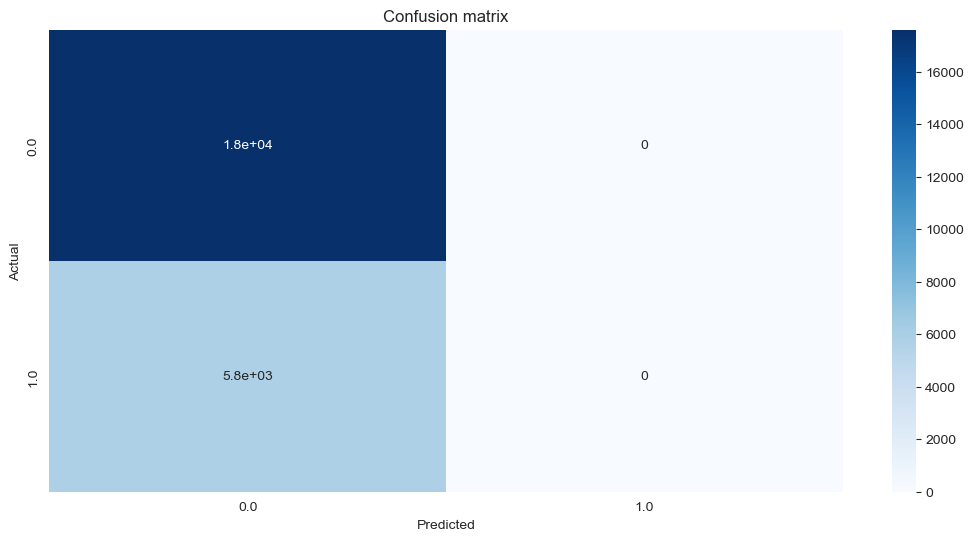

In [151]:
f1,acc = display_results(pd.Series([row[1] for row in encoder.fit_transform(y_val.values.reshape(-1, 1))]),pd.Series(np.round([row[1] for row in a])))

In [129]:
results = random_search.cv_results_

best_svm = random_search.best_estimator_ 
best_scorer_index = np.nonzero(results['rank_test_Accuracy'] == 1)[0][0]
best_scorer_index


0

c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86     17596
         1.0       0.00      0.00      0.00      5826

    accuracy                           0.75     23422
   macro avg       0.38      0.50      0.43     23422
weighted avg       0.56      0.75      0.64     23422



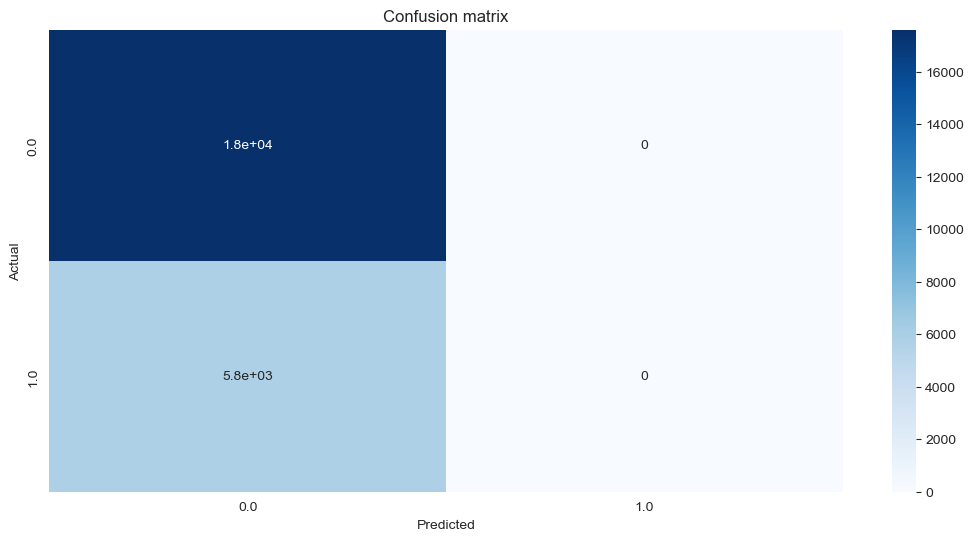

In [152]:
best_svm.fit(X_train, y_train)
svm_pred = best_svm.predict(X_val)

f1,acc = display_results(pd.Series([row[1] for row in encoder.fit_transform(y_val.values.reshape(-1, 1))]),pd.Series([row[1] for row in svm_pred]))

In [102]:
# y_val_ecoded = encoder.fit_transform(y_val.values.reshape(-1, 1))
